# Comparing Vegas generated without scanning with the KDE prediction in observables

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from parameters_dict import physics_parameters
from exp_analysis_class import exp_analysis
from plot_utils import *

## Get objects for all 4 cases 

In [3]:
load_all = True

In [4]:
if load_all:
    my_exp_analyses = {}
    from itertools import product
    for hierarchy, D_or_M in product(['heavy'], ['dirac', 'majorana']):
        print(hierarchy, D_or_M)
        save_folder = f'../fig/3_comparison_observables/{hierarchy}_{D_or_M}/'
        !mkdir -p $save_folder
        this_exp_analyis = exp_analysis(hierarchy, D_or_M)
        this_exp_analyis.load_df_base(1000000)
        this_exp_analyis.load_grid_dfs()
        my_exp_analyses[f'{hierarchy}_{D_or_M}'] = this_exp_analyis

heavy dirac
heavy majorana


##### Examples

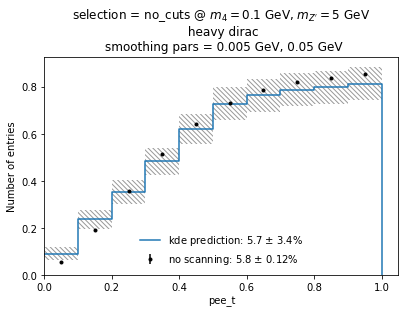

In [77]:
kde_to_noscan_comparison(var='pee_t',
                       range=(0, 1),
                       bins=10,
                       m4mz=(0.1, 5),
                       exp_analysis_obj=my_exp_analyses['heavy_dirac'],
                       smoothing_pars=(0.005, 0.05),
                       selection_query='no_cuts',
                       cumulative=True)

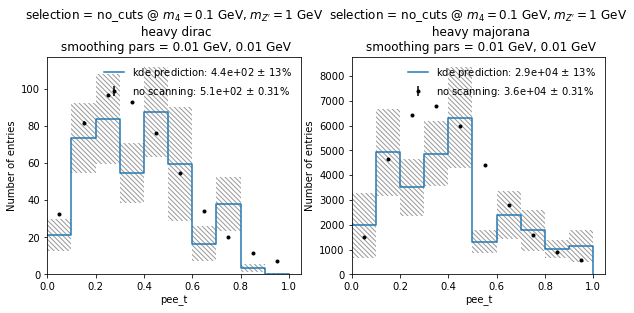

In [81]:
comparison_plot_models(var='pee_t',
                       range=(0, 1),
                       bins=10,
                       m4mz=(0.1, 1),
                       exp_analysis_objs=[my_exp_analyses['heavy_dirac'], my_exp_analyses['heavy_majorana']],
                       existing_axes=None,
                       smoothing_pars=(0.01,0.01),
                       selection_query='no_cuts',
                       cumulative=False);

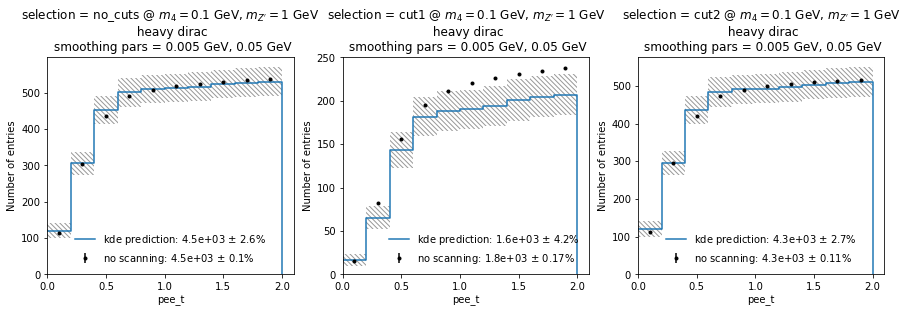

In [82]:
comparison_plot_cuts(var='pee_t',
                       range=(0, 2),
                       bins=10,
                       m4mz=(0.1, 1),
                       exp_analysis_obj=my_exp_analyses['heavy_dirac'],
                       smoothing_pars=(0.005, 0.05),
                       selection_queries=['no_cuts', 'cut1', 'cut2'],
                       cumulative=True);

## Efficiency

### Single efficiency for KDE

In [83]:
kde_efficiency(num_selection_query='cut1',
               den_selection_query='no_cuts',
               m4mz=(0.1, 0.5),
               exp_analysis_obj=my_exp_analyses['heavy_dirac']
               )

(0.4969012434222373, 0.03619320243087847)

### Single efficiency for no scan

In [84]:
no_scan_efficiency(num_selection_query='cut1',
               den_selection_query='no_cuts',
               m4mz=(0.1, 1),
               exp_analysis_obj=my_exp_analyses['heavy_dirac']
               )

(0.46069093409473433, 0.0014750142567100857)

### Efficiency for multiple cuts

(array([0.88350493, 0.99591479, 1.01379066, 0.94927798, 0.85757479]),
 array([0.07720047, 0.00867956, 0.00569651, 0.03718581, 0.07905283]))

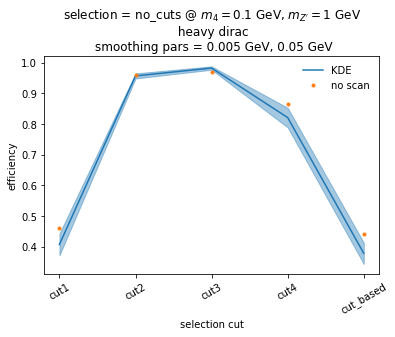

In [85]:
kde_no_scan_efficiency_cut_list(num_selection_queries=['cut1', 'cut2', 'cut3', 'cut4', 'cut_based'], 
                                den_selection_queries='no_cuts', 
                                exp_analysis_obj=my_exp_analyses['heavy_dirac'], 
                                m4mz=(0.1, 1),
                                smoothing_pars=[0.005, 0.05])

### Efficiency for multiple c$\tau$ (finally!!!)

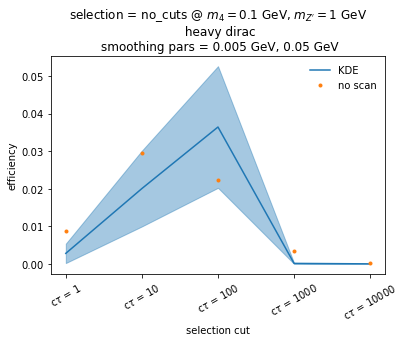

In [89]:
ctaus = [1, 10, 100, 1000, 10000]
my_exp_analyses['heavy_dirac'].ctau_acceptance(ctaus)

kde_no_scan_efficiency_cut_list(num_selection_queries=[f'decay_in_tpc_{ctau}' for ctau in ctaus], 
                                den_selection_queries='no_cuts', 
                                exp_analysis_obj=my_exp_analyses['heavy_dirac'], 
                                m4mz=(0.1, 1),
                                smoothing_pars=[0.005, 0.05]);
plt.xticks(range(len(ctaus)), labels=[f'c$\\tau$ = {ctau}' for ctau in ctaus]);

## Example of plotting comparisons for a single observable -- ee energy
## It needs to be updated!

In [ ]:
bins = 10
var1='ee_energy'
var2=''
varmin=0; varmax=1.0
fig,  axes = plt.subplots(nrows=1, ncols=4,figsize = (18,4))

# Heavy
m4mz = (0.1, 1)
smooth=(0.02,0.01)
exp_analyses=[my_exp_analysis_hd,my_exp_analysis_hm]
batch_comparison_plot(axes[:2],exp_analyses, m4mz,var1,var2,smooth=smooth,var_range=(varmin,varmax), bins=bins)

# light
m4mz = (0.4, 0.1)
smooth=(0.02,0.02)
exp_analyses=[my_exp_analysis_ld,my_exp_analysis_lm]
batch_comparison_plot(axes[2:],exp_analyses, m4mz,var1,var2,smooth=smooth,var_range=(varmin,varmax), bins=bins)

plt.tight_layout()

## Comparing (heavy light)(maj dir) for all variables 

plots stored in multi-page pdf in plots/generation_KDE_comparisons/

In [ ]:
%%capture
m4mzheavy= (0.1, 1)
m4mzlight = (0.4, 0.03)

# cases for each panel
exp_analyses=[my_exp_analysis_hd,my_exp_analysis_hm,my_exp_analysis_ld,my_exp_analysis_lm]

batch_comparison_light_heavy(f"../plots/generation_KDE_comparisons/m4H_{m4mzheavy[0]}_mzH_{m4mzheavy[1]}_m4L_{m4mzlight[0]}_mzL_{m4mzlight[1]}.pdf", 
                           exp_analyses,m4mzheavy,m4mzlight)

In [ ]:
%%capture
m4mzheavy= (0.01, 1)
m4mzlight = (0.4, 0.03)

s# cases for each panel
exp_analyses=[my_exp_analysis_hd,my_exp_analysis_hm,my_exp_analysis_ld,my_exp_analysis_lm]

batch_comparison_light_heavy(f"../plots/generation_KDE_comparisons/m4H_{m4mzheavy[0]}_mzH_{m4mzheavy[1]}_m4L_{m4mzlight[0]}_mzL_{m4mzlight[1]}.pdf", 
                           exp_analyses,m4mzheavy,m4mzlight)

## Compare different cut stages for a single (heavy light)(maj dir) case

In [ ]:
%%capture
m4mz= (0.1, 0.03)

exp_analyses=[my_exp_analysis_lm]*4
# varying var range for light case -- standard def is better for heavy case
var_range = [(0,1.0),
            (0,np.pi/4),
            (0,m4mz[0]),
            (-1,1.0),
            (0,np.pi/4),
            (0,np.pi/4),
            (0,0.01)]
smooth_light=(0.02,0.02)
batch_comparison_cutlevels(f"../plots/generation_KDE_comparisons/cut_flow_m4_{m4mz[0]}_mz_{m4mz[1]}.pdf", 
                           exp_analyses, m4mz, smooth = smooth_light,
                           var_range=var_range,
                           sel_criterion=['no_cuts', 'cut1', 'cut2', 'cut_based'])  

In [ ]:
%%capture
m4mz= (0.1, 1)
exp_analyses=[my_exp_analysis_hm]*4

batch_comparison_cutlevels(f"../plots/generation_KDE_comparisons/cut_flow_m4_{m4mz[0]}_mz_{m4mz[1]}.pdf", 
                           exp_analyses, m4mz, sel_criterion=['no_cuts', 'cut1', 'cut2', 'cut_based'])